# Mission
Vous êtes consultant pour *Olist*, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

**Olist** souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de **comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.

Vous devrez **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une **proposition de contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps.

## Les données
Pour cette mission, Olist vous fournit une *base de données* anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

## Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

Vous créez donc un notebook et démarrez votre travail.
# Simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation
L'objectif est d'estimer la dégradation d'un clustering initial dans le temps.

En effet, pour une même clientèle, les variables RFM évoluent temporellement et donc les clients sont susceptibles basculer d'un cluster à un autre.

Cette **instabilité du clustering** peut être mesurée avec l'*Indice Rand Ajusté* (**ARI**) et au-delà d'une certaine dérive, il sera nécessaire de réinitialiser le modèle de clustering.
## Import des librairies utilisées

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score

## Paramétrage d'affichage

In [2]:
sns.set_theme(style='whitegrid', palette='pastel')

## Import du dataset
Il me faut récupérer un dataframe initial, nettoyé, mais avant le features engineering, afin de pouvoir construire autant de dataframes que de périodes d'observations souhaitées.

Le dataframe initial doit contenir les variables :
- order_purchase_timestamp
- customer_unique_id
- order_id
- payment_value

In [3]:
data = pd.read_csv('simulation.csv', encoding='utf-8')
df = data.copy()
df.dtypes

order_purchase_timestamp     object
customer_unique_id           object
order_id                     object
payment_value               float64
dtype: object

Les dates sont au format *object*.
## Préparation du dataframe
### Transformation des dates en vraies dates

In [4]:
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp'], format='%Y/%m/%d', errors='coerce')
df.head(1)

,order_purchase_timestamp,customer_unique_id,order_id,payment_value
0,2017-05-16 15:05:35,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87


In [5]:
print('Date de commande la plus ancienne :',
      df['order_purchase_timestamp'].min())
print('Date de commande la plus récente :',
      df['order_purchase_timestamp'].max())

Date de commande la plus ancienne : 2016-09-04 21:15:19
Date de commande la plus récente : 2018-10-17 17:30:18


### Création d'une ligne chronologique en jours démarrant à la date de la plus ancienne commande

In [6]:
df['d_day'] = (df['order_purchase_timestamp'] -
               df['order_purchase_timestamp'].min()).dt.days
df.head(1)

,order_purchase_timestamp,customer_unique_id,order_id,payment_value,d_day
0,2017-05-16 15:05:35,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,253


In [7]:
print('La commande la plus récente a été passée',
      df['d_day'].max(), 'jours après la première commande.')

La commande la plus récente a été passée 772 jours après la première commande.


La date devient inutile :

In [8]:
df = df.drop(columns='order_purchase_timestamp')
df.head(1)

,customer_unique_id,order_id,payment_value,d_day
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,146.87,253


## Création des dataframes pour les calculs de *ARI*
Les dataframes seront construits avec des paramètres :
- jour *day0* de fin de première période
- intervalle *deltaday* de périodicité des plages d'observation supplémentaires
### Fonction d'extraction du dataframe

In [9]:
def df_builder(day):
    """Build a dataframe to be used in computing ARI score"""

    df_extracted = df.loc[df['d_day'] <= day]
    df_extracted = df_extracted.copy()
    df_extracted['recency'] = day - df_extracted['d_day']
    df_build_recency = df_extracted.groupby(
        'customer_unique_id').agg({'recency': 'min'})
    df_build_frequency = df_extracted.groupby(
        'customer_unique_id').agg({'order_id': 'nunique'})
    df_build_frequency = df_build_frequency.rename(
        columns={'order_id': 'frequency'})
    df_build_monetary = df_extracted.loc[~(
        df_extracted.duplicated(subset=['order_id', 'payment_value']))]
    df_build_monetary = df_build_monetary.groupby(
        'customer_unique_id').agg({'payment_value': 'sum'})
    df_build_monetary = df_build_monetary.rename(
        columns={'payment_value': 'monetary'})
    df_built = pd.merge(df_build_recency, df_build_frequency,
                        left_index=True, right_index=True)
    df_built = pd.merge(df_built, df_build_monetary,
                        left_index=True, right_index=True)

    return df_built.values

## Création de modèle de clustering
Les paramètres du modèle sont ceux choisis lors des essais de modélisation :

In [10]:
kmeans = KMeans(n_clusters=4, n_init=1, init='k-means++', random_state=39)

### Fonction d'instanciation d'un scaler et d'un modèle de clustering à une date donnée

In [11]:
def clustering(data):
    """ Sorts clustering parameters by KMeans of a dataframe that needs to be normalized too. """
    scaler = preprocessing.StandardScaler().fit(data)
    X_scaled = scaler.transform(data)
    return scaler, kmeans.fit(X_scaled)

## Indice de Rand Ajusté (ARI)
Le principe est de mesurer l'obsolescence d'un modèle de segmentation en comparant un modèle établi à une date donnée avec un modèle mis à jour.

In [12]:
def ari(day0, deltaday):
    """ Uses former functions to compute the evolution of the ARI score. """
    aris = []
    df_0 = df_builder(day0)
    scaler_0, kmeans_0 = clustering(df_0)
    intervals = np.arange(day0, df['d_day'].max(), deltaday)
    for i in intervals:
        df_i = df_builder(i)
        X_scd_0 = scaler_0.transform(df_i)
        X_0_i = kmeans_0.predict(X_scd_0)
        scaler_i, kmeans_i = clustering(df_i)
        X_scd_i = scaler_i.transform(df_i)
        X_i_i = kmeans_i.predict(X_scd_i)
        ari = adjusted_rand_score(X_0_i, X_i_i)
        aris.append(ari)
    fig = plt.figure(figsize=(13, 8))
    plt.plot(intervals-day0, aris)
    plt.plot([0, intervals[-1]-day0], [0.8, 0.8], color='red')
    plt.title(
        "Evolution du score ARI pour apprécier le besoin de renouvellement du modèle", fontsize=15)
    plt.xlabel('Jours', fontsize=14)
    plt.ylabel('ARI', fontsize=14)
    plt.show()

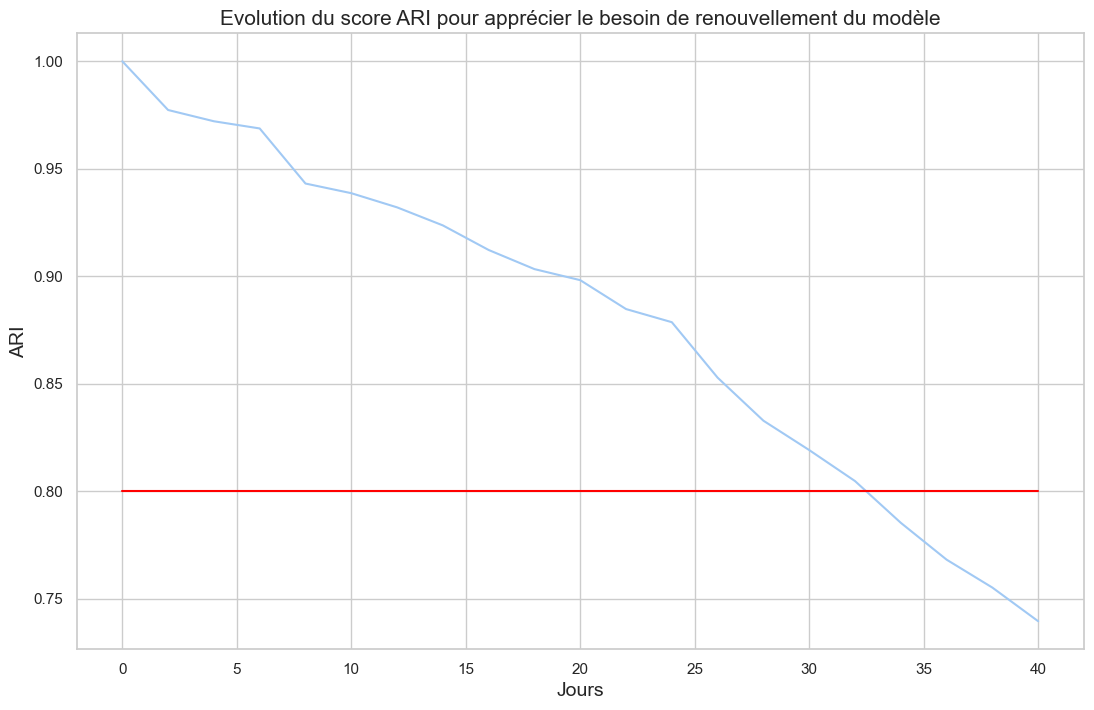

In [13]:
ari(730, 2)

## Conclusion
En considérant un **ARI** score < **80%** comme signal d'alerte, le modèle de segmentation nécessiterait d'être réactualisé tous les **32 jours**, ou sinon toutes les **4 semaines**, ou encore **une fois par mois** !